<a href="https://colab.research.google.com/github/Marieta3/soft_kompjuting_privatni/blob/master/Copy_of_sc_siit_v2_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Computing

## Vežba 2 - OCR (Optical Character Recognition)

Cilj ovih vežbi je implementacija sistema za optičko prepoznavanje karaktera (OCR).<br>
Za rad sa neuronskim mrežama koristićemo <a href="https://keras.io/">Keras</a> biblioteku. 

### Tok aktivnosti implementacije OCR-a

Tok aktivnosti predstavlja korake koje je potrebno izvršiti prilikom implementacije OCR-a. 

<img src="https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/tok_aktivnosti.png?raw=1"/>

### Početak implementacije

Skup paketa/biblioteka sa prethodnih vežbi smo proširili Keras bibliotekom za rad sa neuronskim mrežama.

In [0]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections

In [0]:
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12

In [0]:
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

### Koraci [1, 3]

Ovi koraci su detaljno objašnjeni na prethodnim vežbama.

In [0]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Korak 4 - Izdvajanje regiona od interesa

U ovom koraku potrebno je izdvojiti samo regione (konture) od interesa. Potrebno je označiti regione od interesa na slici i napraviti listu slika od regiona koja će kasnije biti ulaz za neuronsku mrežu.

Kako bi svi regioni koje ćemo koristiti za neuronsku mrežu biti iste veličine, implementiraćemo metodu za promenu veličine slike na 28 x 28.

In [0]:
def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

In [0]:
!wget -cq https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/test_resize.png?raw=true

In [0]:
plt.imshow(brojevi_gray, 'gray')

In [0]:
# test za proveru rada 
#interpolacija za reskaliranje, npr od 4 piksela na 9
#popunjava se sredinama okoline piksela
test_resize_img = load_image('test_resize.png?raw=true')
test_resize_ref = (28, 28)
test_resize_res = resize_region(test_resize_img).shape[0:2]
print("Test resize passsed: ", test_resize_res == test_resize_ref)


Test resize passsed:  True


In [0]:
display_image(test_resize_img)

Metoda za označavanje regiona od interesa treba da označi regione od interesa na originalnoj slici i za svaki region napravi posebnu sliku dimenzija 28 x 28. Kao povratnu vrednost vraća originalnu sliku na kojoj su obeleženi regioni i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti **X** ose.

Za potrebe označavanja regiona iskoristićemo **boundingRect**, a za obeležavanje regiona **rectangle** metodu OpenCV-ja.

In [0]:
def select_roi(image_orig, image_bin):
    _, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        #zasto 100? 30*42 sa malim greskama
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

### Korak 5 - Priprema podataka za obučavanje

Regioni od interesa su predstavljeni vektorom čiji su elementi matrice dimenzija 28 x 28. Elementi matrica su vrednosti 0 ili 255. Potrebno je skalirati vrednosti elemenata matrice na opseg [0, 1], kako bi se pogodio linearni deo sigmoid funkcije i smanjilo vreme obučavanja. Podelimo sa 255. Nakon skaliranja, matrice je potrebno transformisati u vektor od 784 elementa.

In [0]:
def scale_to_range(image):
    return image/255

In [0]:
# test za proveru
test_scale_matrix = np.array([[0, 255], [51, 153]], dtype='float')
test_scale_ref = np.array([[0., 1.], [0.2, 0.6]], dtype='float')
test_scale_res = scale_to_range(test_scale_matrix)
print("Test scale passed: ", np.array_equal(test_scale_res, test_scale_ref))

Test scale passed:  True


In [0]:
def matrix_to_vector(image):
    return image.flatten()

In [0]:
test_mtv = np.ndarray((28, 28))
test_mtv_ref = (784, )
test_mtv_res = matrix_to_vector(test_mtv).shape
print("Test matrix to vector passed: ", test_mtv_res == test_mtv_ref)

Test matrix to vector passed:  True


In [0]:
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann
#vraca pobudjenost za svaki neuron od 0 do 1

Potrebno je konvertovati alfabet u niz pogodan za obučavanje neuronske mreže, odnosno niz čiji su svi elementi 0 osim elemenata čiji je indeks jednak indeksu elementa iz alfabeta za koji formiramo niz. 

Primeri:
<ul>
    <li>Prvi element alfabeta: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],</li>
    <li>Drugi element alfabeta: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] itd.</li>
</ul>

In [0]:
def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

In [0]:
# test konverzije
test_convert_alphabet = [0, 1, 2]
test_convert_ref = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype='float')
test_convert_res = convert_output(test_convert_alphabet).astype('float')
print("Test convert output: ", np.array_equal(test_convert_res, test_convert_ref))

Test convert output:  True


### Koraci [6, 7]

Veštačka neuronska mreža se sastoji od 784 ulazna neurona, 128 neurona u skrivenom sloju i 10 neurona na izlazu. 

Zašto baš 784 neurona na ulazu i 10 neurona na izlazu?

Regione smo transformisali prvo na matricu dimenzija 28 x 28, a zatim u vektor od 784 elementa. Broj neurona na izlazu je posledica broja znakova u alfabetu. 

<img src="https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/neuronska_mreza.png?raw=1" />

In [0]:
def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

In [0]:
def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

### Korak 8 - Određivanje pobedničkog neurona

Pobednički neuron je neuron čija je aktivaciona vrednost najveća.

In [0]:
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

In [0]:
# test winner
test_winner_output = [0., 0.2, 0.3, 0.95]
test_winner_ref = 3
test_winner_res = winner(test_winner_output)
print("Test winner passed: ", test_winner_res == test_winner_ref)

Test winner passed:  True


### Korak 9 - Prikaz rezultata

Prikaz rezultata prepoznavanja. Za svaki rezultat je potrebno pronaći indeks pobedničkog neurona koji ujedno predstavlja i indeks prepoznatog elementa u alfabetu. Karakter se dodaje u rezultujuću listu.

In [0]:
def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

### TODO 1:

* Učitati sliku za obučavanje veštačke neuronske mreže: **images/brojevi.png**.
* Transformisati sliku u binarni oblik i označiti regione od interesa. Prikazati sliku sa označenim regionima od interesa.

In [0]:
brojevi_img = load_image('brojevi.png?raw=true')
brojevi_gray = image_gray(brojevi_img)
brojevi_bin = image_bin(brojevi_gray)
brojevi_bin = erode(dilate(brojevi_bin))


In [0]:
selected_regions, numbers = select_roi(brojevi_img, brojevi_bin)


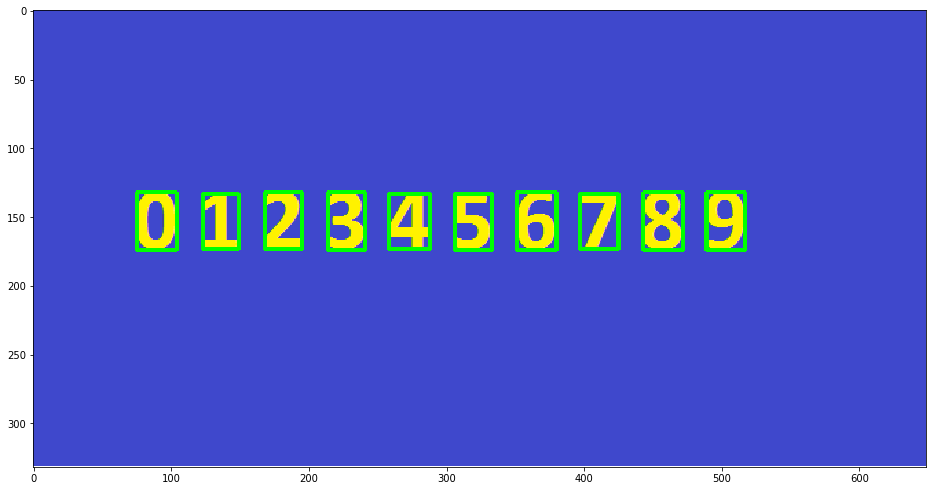

In [0]:
display_image(selected_regions)

### TODO 2: 

* Definisati alfabet i izvršiti treniranje veštačke neuronske mreže.

In [0]:
alfabet = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
inputs =prepare_for_ann(numbers)
outputs = convert_output(alfabet)
ann = create_ann(output_size=10)
ann = train_ann(ann, inputs, outputs, epochs=128)


### TODO 3: 

* Verifikovati obučenost neuronske mreže uz pomoć trećeg i četvrtog ulaznog vektora (brojevi 2 i 3). 

In [0]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print("result")
print("\n")
print(display_result(result, alfabet))


result


[2, 3]


### TODO 4:

* Učitati sliku za testiranje rada OCR-a: **images/test.png**.
* Transformisati sliku u oblik pogodan za ulaz u neuronsku mrežu.
* Prikazati rezultate predikcije kao i sliku sa označenim regionima od interesa.

### K - Means

Kada je reč o čitanju stvarnog teksta, deo problema predstavlja i određivanje granica između reči i redova u tekstu. Kao rešenje moguće je koristiti K-Means algoritam i klasterizovati razmak između regiona u dva klastera:  
* Razmak između slova u reči i  
* Razmak između reči.

Koristićemo <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">scikit-learn</a> implementaciju K-Means algoritma.

In [0]:
from sklearn.cluster import KMeans

Potrebno je prvo modifikovati metodu za određivanje regiona od interesa tako da vraća i vrednosti rastojanja po X osi, između svih regiona.

In [0]:
def select_roi_with_distances(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1, x:x+w+1]
        regions_array.append([resize_region(region), (x, y, w, h)])
        cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    
    sorted_regions = [region[0] for region in regions_array]
    sorted_rectangles = [region[1] for region in regions_array]
    region_distances = []
    # izdvojiti sortirane parametre opisujucih pravougaonika
    # izracunati rastojanja izmedju svih susednih regiona po X osi i dodati ih u niz rastojanja
    for index in range(0, len(sorted_rectangles) - 1):
        current = sorted_rectangles[index]
        next_rect = sorted_rectangles[index + 1]
        distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
        region_distances.append(distance)
    
    return image_orig, sorted_regions, region_distances

Zatim se vrši modifikacija metode za prikaz rezultata, tako da formira string sa razmacima između reči. Metodi je neophodno proslediti obučen KMeans objekat kako bi odredila koja grupa rastojanja predstavlja razmak između reči, a koja između slova, i na osnovu toga formirala string od elemenata pronađenih sa slike. 

In [0]:
def display_result_with_spaces(outputs, alphabet, k_means):
    # odredjivanje indeksa grupe koja odgovara rastojanju izmedju reci
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    # iterativno dodavanje prepoznatih elemenata
    # dodavanje space karaktera ako je rastojanje izmedju dva slova odgovara rastojanju izmedju reci
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

### TODO 5:  

* Učitati sliku za obučavanje veštačke neuronske mreže: **images/alphabet.png**.  
* Prikazati sliku sa označenim regionima od interesa.

In [0]:
!wget -cq https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/alphabet.png?raw=true

In [0]:
alf_img = load_image('alphabet.png?raw=true')

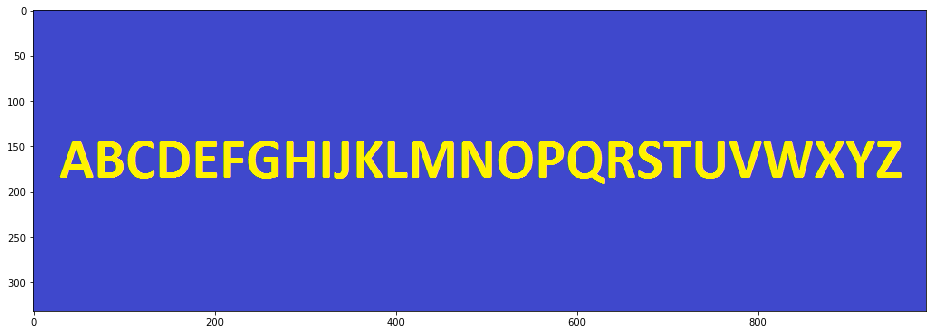

In [0]:
display_image(alf_img)

In [0]:
alf_gray = image_gray(alf_img)
alf_bin = image_bin(alf_gray)
alf_bin = erode(alf_bin)

In [0]:
selected_regions_alf, letters_alf = select_roi(alf_img, alf_bin)

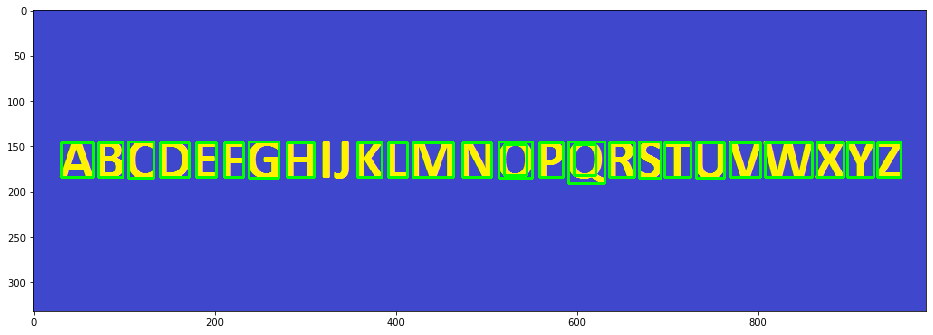

In [0]:
display_image(selected_regions_alf)

### TODO 6:  

* Definisati alfabet i izvršiti treniranje veštačke neuronske mreže

In [0]:
alf = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
inputs =prepare_for_ann(letters_alf)
outputs = convert_output(alf)
ann = create_ann(output_size=26)
ann = train_ann(ann, inputs, outputs, epochs=128)



Training started...

Training completed...


In [0]:
result = ann.predict(np.array(inputs, np.float32))
print("result")
print("\n")
print(display_result(result, alf))

result


['A', 'B', 'C', 'D', 'F', 'F', 'C', 'U', 'I', 'N', 'Q', 'Q', 'M', 'Q', 'F', 'P', 'Q', 'X', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### TODO 7:  

* Učitati sliku za testiranje: **images/lorem_impsum.png**.  
* Odrediti regione od interesa i rastojanja među njima.  
* Iskoristiti KMeans za grupisanje rastojanja u dve grupe.  
* Prikazati rezultat predikcije i sliku sa označenim regionima od interesa.

In [0]:
!wget -cq https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/lorem_ipsum.png?raw=true 

In [0]:
lorem_img = load_image('lorem_ipsum.png?raw=true')

## Kompleksniji OCR

OCR sistemi vrše optičko prepoznavanje tekstualnih sadržaja sa fotografija, gde je fotografija ulazni parametar sistema. Performanse sistema će u mnogome zavisiti od pretpostavke o ulaznoj fotografiji. Pošto se takva fotografija pravi u realnom okruženju, normalno je za očekivati dosta spoljnih uticaja. Ukoliko pretpostavimo da ulazna fotografija neće biti pod uticajem određenog broja faktora iz okruženja sistem može da se pojednostavi. Recimo, kamere u industrijskim pogonima prave fotografije u okruženju u kome se nivo osvetljenja može kontrolisati, uređaj za fotografisanje je uvek isti i pravi fotografije koje su "sličnog" oblika.

Do sada smo OCR sistem implementirali uz pretpostavku da je fotografija idealna i da je tekstualni sadržaj na njoj prost. Međutim, to najčešće nije slučaj. Ulazna fotografija će obično izgledati ovako:

<img src="https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/cifre.jpg?raw=1"/>

### Obrada digitalne slike

Obrada digitalne slike predstavlja prvi skup aktivnosti OCR sistemu. Cilj ovog skupa aktivnosti jeste prilagođavanje ulazne fotografije da bi se nad njom mogla vršiti analiza sadržaja. Obrada digitalne slike može biti dosta složen proces, pošto bi on trebao biti u stanju da obradi bilo kakvu ulaznu fotografiju. Proces analize digitalne slike će biti mnogo jednostavniji ukoliko se fotografija prethodno dobro obradi i ukloni većina šuma.

#### Neuniformna osvetljenost fotografije

Cilj segmentacije jeste klasifikovanje piksela fotografije u one koji pripadaju sadržaju i one koji pripadaju pozadini. Do sada smo za segmentaciju koristili metode bazirane na računanju praga - **threshold**. Ukoliko se za celu fotografiju pronađe jedan prag segmentacije, problem se javlja ako su delovi fotografije osetno manje ili više osvetljeni od ostatka fotografije. Ovaj problem se može rešiti uz korišćenje adaptivnog threshold-a. Na taj način se može rešiti problem neuniformna osvetljenosti fotografije.

In [0]:
image_color = load_image('images/cifre2.jpg')
img = image_bin(image_gray(image_color))
display_image(img)

#### Šum na fotografiji nakon segmentacije

Proces segmentacije će pokušati da klasifikuje piksele tako da ih obeleži da pripadaju sadržaju ili pozadini, ali ne mora da znači da će u tome biti 100% uspešan. Na fotografiji koja je rezultat procesa segmentacije može postojati šum koji može znatno otežati analizu ovakve fotografije u narednim koracima OCR-a. Zbog toga je takav šum potrebno ukloniti u što većoj meri u ranim fazama.

### Analiza digitalne slike

Analiza digitalne slike počinje kreiranjem skupa regiona(kontura) sa binarne slike. Takav skup regiona je potrebno analizirati i izvršiti njihovo prepoznavanje. Problem predstavlja činjenica da region ne mora izgledati uvek isto, iako predstavlja isti karakter. Jedan primer takve situacije jeste rotacija.

#### Zarotirani simboli na fotografiji

Svaki region se skalira na dimenzije 28 x 28 i formira matricu, a nakon toga se pretvara u vektor od 784 elementa. Očigledno je da će takva matrica izgledati drugačije ukoliko je region zarotiran, što će rezultovati činjenicom da ćemo na ulaz neuronske mreže dovesti ulazni vektor koji će jako loše opisivati region koji bi on trebalo da predstavlja. Posledica će biti loša predikcija od strane veštačke neuronske mreže. Zbog toga je regione potrebno zarotirati tako da se oni postave u prirodan položaj.

Tačke regiona je potrebno rotirati oko tačke **(c<sub>x</sub>, c<sub>y</sub>)** za zadati ugao **$\alpha = \pi / 2 - |\theta|$** gde su **c<sub>x</sub>, c<sub>y</sub> i $\theta$** parametri dobijeni iz osobina regiona. Na ovaj način treba da se dobiju slike regiona koje su "relativno" vertikalne. 

Formula za rotiranje tačke sa koordinatama **(x,y)** za ugao **$\alpha$** oko tačke sa koordinatama **(c<sub>x</sub>, c<sub>y</sub>)**:
<img src="https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/rotacija.jpg?raw=1"/>

#### Simboli koji se sastoje iz više regiona

Činjenica da se jedan simbol ne mora sastojati iz samo jednog regiona nama može predstavljati problem (npr: i, ž, ć...). Zbog toga je potrebno izvršiti spajanje kukica i kvačica u okolini simbola pre slanja podataka na predikciju neuronskoj mreži.

<img src="https://github.com/ftn-ai-lab/sc-2019-siit/blob/master/v2-ocr/images/slovo.jpg?raw=1"/>

Nakon spajanja kukica i kvačica na red dolazi skaliranje regiona na dimenzije 28 x 28. Region je sada niz tačaka čije su koordinate apsolutne koordinate na fotografiji sa koje su regioni preuzeti. Kako bi se isekao pravougaonik oko regiona potrebno je proći kroz sve tačke regiona i koordinate svake od njih prebaciti iz apsolutnih u relativne koordinate u odnosu na poziciju tačke unutar regiona.

## Zadaci

### Zadatak 1 - Kalkulator

Implementirati OCR za kalkulator. Obučiti sistem na **images/kalkulator_alfabet.png**. Testirati na:
* **images/sabiranje.png**
* **images/oduzimanje.png**
* **images/slozen_izraz.png**

### Zadatak 2 - Redovi

Implementirati OCR koji će moći čitati tekst sa više redova. Obučiti sistem na **images/alphabet.png**. Testirati na: **images/redovi.png**.

### Zadatak 3 - Kukice

Implementirati OCR koji će moći čitati simbole koji se sastoje iz više regiona. Obučiti sistem na **images/obucavanje.jpg**. Testirati na **images/testiranje.jpg**.